# Installing Packages

In [123]:
import sys
!{sys.executable} -m pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [1]:
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
import pickle
import os
import properscoring as ps
from shapely.geometry import box
from shapely.geometry import Point

import tensorflow as tf
from tensorflow.keras import Sequential, Input
import tensorflow_probability as tfp
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, SpatialDropout2D, GlobalAveragePooling2D


2025-01-21 06:54:49.044144: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-21 06:54:49.047228: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-21 06:54:49.088635: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-21 06:54:49.089361: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-21 06:54:52.269234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# 1) Assembling Dataset

In [2]:
# Load GeoTIFF multiband spectral image

file_path1 = "Multispectral raster 1.tif"
file_path2 = "Multispectral raster 2.tif"
cu_file_path = "clean_geochem_df.pkl"

In [3]:
# Confirming the bounds of the images

with rasterio.open(file_path1) as dataset:
    bounds1 = dataset.bounds
    crs1 = dataset.crs
    resolution1 = dataset.res
    img = dataset.read(1)
    
with rasterio.open(file_path2) as dataset:
    bounds2 = dataset.bounds
    crs2 = dataset.crs
    resolution2 = dataset.res

print("Image bounds:", bounds1)
print("Coordinate reference system (CRS):", crs1)
print("Pixel resolution:", resolution1)

print("Image bounds:", bounds2)
print("Coordinate reference system (CRS):", crs2)
print("Pixel resolution:", resolution2)

Image bounds: BoundingBox(left=479295.0, bottom=8713575.0, right=568305.0, top=8802045.0)
Coordinate reference system (CRS): EPSG:32619
Pixel resolution: (30.0, 30.0)
Image bounds: BoundingBox(left=479295.0, bottom=8713575.0, right=568305.0, top=8802045.0)
Coordinate reference system (CRS): EPSG:32619
Pixel resolution: (30.0, 30.0)


In [88]:
# Function normalises pixel values for each band

def band_normalisation(file_path):
    
    normalised_bands = []
    
#   Landsat-8 has data rescaled to digital numbers from 0 - 65536
    for band in range(1,6):
        # Open GeoTIFF file
        with rasterio.open(file_path) as src:
            L8_raster = src.read(band)

        # Convert GeoTIFF to tensor
        L8_raster = np.array(L8_raster)
        L8_tensor = tf.convert_to_tensor(L8_raster, dtype=tf.float32)
        
        # Normalise all values in tensor
        normalised_L8_tensor = L8_tensor / 65536
        normalised_bands.append(normalised_L8_tensor)

#   ASTER has data rescaled to digital numbers from 0 - 255
    for band in range(6,9):
        # Open GeoTIFF file
        with rasterio.open(file_path) as src:
            aster_raster = src.read(band)

        # Convert GeoTIFF to tensor
        aster_raster = np.array(aster_raster)
        aster_tensor = tf.convert_to_tensor(aster_raster, dtype=tf.float32)
        
        # Normalise all values in tensor
        normalised_aster_tensor = aster_tensor / 255
        normalised_bands.append(normalised_aster_tensor)
    
#   Stacking normalised bands as tensors
    stacked_tensor = np.stack(normalised_bands, axis=-1)
    stacked_tensor = tf.expand_dims(stacked_tensor, axis=0)  # Add batch dimension for shape = (batch_size, height, width, bands)


    return stacked_tensor          

In [89]:
normalised_tensor_1 = band_normalisation(file_path1)
print(normalised_tensor_1.shape)

normalised_tensor_2 = band_normalisation(file_path2)
print(normalised_tensor_2.shape)

(1, 2949, 2967, 8)
(1, 2949, 2967, 8)


In [ ]:
# Function extracts patches and removes any where all pixel values are 0

def patchify(image_tensor, patch_size=(64, 64), stride=(64, 64)):
    
    # Extract patches using tf.image.extract_patches
    patches = tf.image.extract_patches(
        images=image_tensor,
        sizes=[1, patch_size[0], patch_size[1], 1],
        strides=[1, stride[0], stride[1], 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    
    # Get the dimensions of the input tensor
    batch_size = tf.shape(image_tensor)[0]
    patch_height, patch_width = patch_size
    num_patches_h = tf.shape(patches)[1]  # Number of patches along height
    num_patches_w = tf.shape(patches)[2]  # Number of patches along width
    channels = tf.shape(image_tensor)[-1]  # Number of channels
    
    # Reshape patches to (num_patches, patch_height, patch_width, channels)
    patches = tf.reshape(
        patches, 
        [batch_size * num_patches_h * num_patches_w, patch_height, patch_width, channels]
    )
    
    return patches

In [ ]:
# height + width split into 46 = 46 x 46 = 2116 patches per image
patches_trainset = patchify(normalised_tensor_1)
print(patches_trainset.shape)

patches_valtestset = patchify(normalised_tensor_2)
print(patches_valtestset.shape)

# with open("patches_trainset.pkl", "wb") as file:
#     pickle.dump(patches_trainset, file)
    
# with open("patches_valtestset.pkl", "wb") as file:
#     pickle.dump(patches_valtestset, file)

In [12]:
with open("patches_trainset.pkl", "rb") as file:
    patches_trainset = pickle.load(file)

with open("patches_valtestset.pkl", "rb") as file:
    patches_valtestset = pickle.load(file)

In [13]:
# Mapping copper points to patches

# Image metadata
image_bounds = {
    'left': 479295.0,
    'bottom': 8713575.0,
    'right': 568305.0,
    'top': 8802045.0
}
pixel_resolution = 30.0  # in meters
patch_size = 64  # in pixels
num_patches_x = 46  # number of patches along x-direction
num_patches_y = 46  # number of patches along y-direction
patch_width = 1920
patch_height = 1920

# Generate patch bounding boxes in UTM coordinates
patch_bboxes = []
for i in range(num_patches_x):
    for j in range(num_patches_y):
        # Calculate lower-left corner (x, y) of the patch
        x = image_bounds['left'] + i * patch_width
        y = image_bounds['bottom'] + j * patch_height
        
        # Create the bounding box using the lower-left and upper-right corners
        patch_bbox = box(x, y, x + patch_width, y + patch_height)
        patch_bboxes.append(patch_bbox)

patches_gdf = gpd.GeoDataFrame(geometry=patch_bboxes, crs="EPSG:32619")
patches_gdf = patches_gdf.rename_axis('patch_id')

patches_gdf

,geometry
patch_id,
0,"POLYGON ((481215.000 8713575.000, 481215.000 8..."
1,"POLYGON ((481215.000 8715495.000, 481215.000 8..."
2,"POLYGON ((481215.000 8717415.000, 481215.000 8..."
3,"POLYGON ((481215.000 8719335.000, 481215.000 8..."
4,"POLYGON ((481215.000 8721255.000, 481215.000 8..."
...,...
2111,"POLYGON ((567615.000 8792295.000, 567615.000 8..."
2112,"POLYGON ((567615.000 8794215.000, 567615.000 8..."
2113,"POLYGON ((567615.000 8796135.000, 567615.000 8..."


In [14]:
# Load copper points from df and convert to gdf with correct CRS
with open(cu_file_path, "rb") as file:
    clean_geochem_df = pickle.load(file)
    
cu_samples_df = clean_geochem_df[["Cu", "Longitude", "Latitude"]]
cu_samples_df = cu_samples_df.copy()
cu_samples_df.loc[:, 'geometry'] = cu_samples_df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

cu_points_df = cu_samples_df[cu_samples_df["Cu"] != 0.0].reset_index()

cu_points_gdf = gpd.GeoDataFrame(cu_points_df, geometry=cu_points_df["geometry"], crs="EPSG:4326")
cu_points_gdf = cu_points_gdf.to_crs(epsg=32619)

cu_points_gdf

,index,Cu,Longitude,Latitude,geometry
0,0,28.0,-24.003230,72.215700,POINT (1903177.498 8571557.975)
1,1,25.0,-23.980030,72.230020,POINT (1902635.460 8573300.958)
2,2,20.0,-24.218880,72.171200,POINT (1901206.257 8562682.110)
3,3,12.0,-24.209870,72.171860,POINT (1901383.663 8562953.470)
4,4,10.0,-24.202410,72.172900,POINT (1901491.783 8563219.134)
...,...,...,...,...,...
18460,19381,49.0,-41.137830,63.213060,POINT (1866892.369 7314439.945)
18461,19382,78.0,-41.470955,63.150892,POINT (1854367.548 7300748.967)
18462,19383,92.0,-41.470955,63.150892,POINT (1854367.548 7300748.967)
18463,19384,53.0,-41.470955,63.150892,POINT (1854367.548 7300748.967)


In [16]:
# Perform the spatial join to check if points fall within any patch
labeled_patches_gdf = gpd.sjoin(patches_gdf, cu_points_gdf,  how="left", predicate="intersects")
labeled_patches_gdf = labeled_patches_gdf[['Cu','geometry']]

# Convert all NaN values to 0
labeled_patches_gdf = labeled_patches_gdf.fillna(0)

# Aggregate Cu values for points in the same patch
labeled_patches_gdf = labeled_patches_gdf.groupby(labeled_patches_gdf.index).agg({"Cu": "mean", "geometry": "first"})
y_labels = labeled_patches_gdf.iloc[:, 0]
copper_present_gdf = labeled_patches_gdf.iloc[labeled_patches_gdf["Cu"].to_numpy().nonzero()[0]]

# Showing only patches with a non-zero Cu value
print("Shape of y variable:", y_labels.shape)
print("Patches with non-zero Cu value:")
display(copper_present_gdf)
display(labeled_patches_gdf)


Shape of y variable: (2116,)
Patches with non-zero Cu value:


,Cu,geometry
patch_id,,
187,78.0,"POLYGON ((488895.000 8719335.000, 488895.000 8..."
293,9.0,"POLYGON ((492735.000 8746215.000, 492735.000 8..."
332,101.0,"POLYGON ((494655.000 8732775.000, 494655.000 8..."
384,97.0,"POLYGON ((496575.000 8744295.000, 496575.000 8..."
431,88.0,"POLYGON ((498495.000 8746215.000, 498495.000 8..."
...,...,...
1914,99.0,"POLYGON ((559935.000 8767335.000, 559935.000 8..."
1957,19.0,"POLYGON ((561855.000 8761575.000, 561855.000 8..."
1963,26.0,"POLYGON ((561855.000 8773095.000, 561855.000 8..."


,Cu,geometry
patch_id,,
0,0.0,"POLYGON ((481215.000 8713575.000, 481215.000 8..."
1,0.0,"POLYGON ((481215.000 8715495.000, 481215.000 8..."
2,0.0,"POLYGON ((481215.000 8717415.000, 481215.000 8..."
3,0.0,"POLYGON ((481215.000 8719335.000, 481215.000 8..."
4,0.0,"POLYGON ((481215.000 8721255.000, 481215.000 8..."
...,...,...
2111,0.0,"POLYGON ((567615.000 8792295.000, 567615.000 8..."
2112,0.0,"POLYGON ((567615.000 8794215.000, 567615.000 8..."
2113,0.0,"POLYGON ((567615.000 8796135.000, 567615.000 8..."


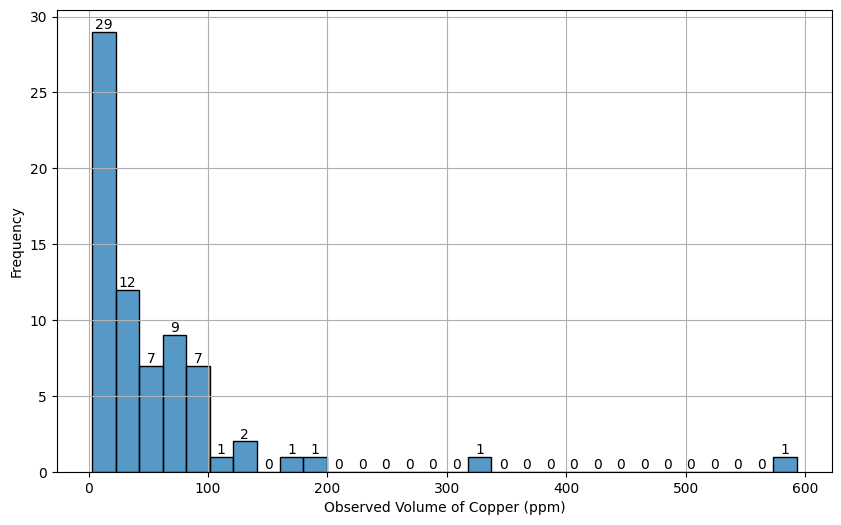

In [26]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=copper_present_gdf, x='Cu', bins=30)
ax.bar_label(ax.containers[0])
plt.xlabel('Observed Volume of Copper (ppm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2) Train/test Split

In [12]:
# Creating indexes for train set indexing

random.seed(35)
train_index = random.sample(range(2116), 1482)
train_index_tf = tf.convert_to_tensor(train_index, dtype=tf.int32)

# Creating indexes for test and validation set indexing whilst ensuring there is no overlap between any sets
valtest_index = list(set(random.sample(range(2116), 2116)) - set(train_index)) # Finding indices not in train_index
shuffled = np.random.permutation(valtest_index) # Shuffling indices remaining in valtest_index
split_index = len(valtest_index) // 2 # Index to split at

test_index = shuffled[:split_index]
test_index_tf = tf.convert_to_tensor(test_index, dtype=tf.int32)

val_index = shuffled[split_index:]
val_index_tf = tf.convert_to_tensor(test_index, dtype=tf.int32)

# Index the TensorFlow datasets
X_train = tf.gather(patches_trainset, train_index_tf)
y_train = tf.gather(y_labels, train_index_tf)

X_test = tf.gather(patches_valtestset, test_index_tf)
y_test = tf.gather(y_labels, test_index_tf)

X_val = tf.gather(patches_valtestset, val_index_tf)
y_val = tf.gather(y_labels, val_index_tf)

print(f"Number of patches in training set: {len(train_index)}")
print(f"Number of patches in testing set: {len(test_index)}")
print(f"Number of patches in validation set: {len(val_index)}")

print(f"\nShape of patches in training set: {X_train.shape}")
print(f"Shape of labels in training set: {y_train.shape}")

print(f"\nShape of patches in testing set: {X_test.shape}")
print(f"Shape of labels in testing set: {y_test.shape}")

print(f"\nShape of patches in validation set: {X_val.shape}")
print(f"Shape of patches in validation set: {y_val.shape}")

Number of patches in training set: 1482
Number of patches in testing set: 317
Number of patches in validation set: 317

Shape of patches in training set: (1482, 64, 64, 8)
Shape of labels in training set: (1482,)

Shape of patches in testing set: (317, 64, 64, 8)
Shape of labels in testing set: (317,)

Shape of patches in validation set: (317, 64, 64, 8)
Shape of patches in validation set: (317,)


# 3) BCNN Model

### 3.1) Model Architecture

In [13]:
# OPTION 1: Defining Model Architecture (no spatial dropout)

# BCNN = Sequential(name="BayesianCNN")

# # Input layer
# BCNN.add(Input(shape=(64, 64, 8)))  # Shape of each patch

# # First convolutional layer with pooling
# BCNN.add(Conv2D(128, (3, 3), activation='relu'))
# BCNN.add(MaxPooling2D(pool_size=(2, 2)))

# # Second convolutional layer with pooling
# BCNN.add(Conv2D(128, (3, 3), activation='relu'))
# BCNN.add(MaxPooling2D(pool_size=(2, 2)))

# # Third convolutional layer
# BCNN.add(Conv2D(128, (3, 3), activation='relu'))

# # Flattening
# BCNN.add(Flatten())

# # Fully connected dense layer
# BCNN.add(Dense(128, activation='relu'))
# # BCNN.add(Dropout(0.3))

# # Output layer (Mean and Log Variance)
# BCNN.add(Dense(2, activation=None))  # No activation for mean and log variance

# # Model summary
# BCNN.summary()

In [14]:
from keras.saving import register_keras_serializable

# Custom loss function for negative log likelihood

@register_keras_serializable() # Allow for custom function to be recognised during unpickling training history

def NLL_loss_function(y, model_output):
    return -tf.reduce_mean(model_output.log_prob(y))

# def normal_distribution(x):
#     return tfd.Normal(
#         loc=x[..., :1],  # Mean
#         scale=1e-3 + tf.math.softplus(0.1 * x[..., 1:])  # Using softplus link function to ensure variance is positive
#     )
def normal_distribution(x):
    mean = x[..., :1]  # Extracting mean
    log_variance = x[..., 1:]  # Extracting log-variance
    variance = tf.math.softplus(log_variance)  # softplus to ensure variance is positive
    return tfd.Normal(loc=mean, scale=variance)

# def normal_distribution(params):
#     mean = params[..., 0]  # Extract mean (shape: (batch_size,))
#     log_variance = params[..., 1]  # Extract log variance (shape: (batch_size,))
#     variance = tf.math.softplus(log_variance)  # Ensure variance is positive
#     return tfd.Normal(loc=mean, scale=tf.sqrt(variance))

In [15]:
# Defining Model Architecture

tfd = tfp.distributions

BCNN = Sequential(name="BayesianCNN")

# Input layer
BCNN.add(Input(shape=(64, 64, 8)))  # Shape of each patch

# First convolutional layer with pooling
BCNN.add(Conv2D(128, (3, 3), activation='relu'))
BCNN.add(SpatialDropout2D(rate=0.3))
BCNN.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer with pooling
BCNN.add(Conv2D(128, (3, 3), activation='relu'))
BCNN.add(SpatialDropout2D(rate=0.3))
BCNN.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
BCNN.add(Conv2D(128, (3, 3), activation='relu'))
BCNN.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening
BCNN.add(GlobalAveragePooling2D())

# Fully connected dense layer
BCNN.add(Dense(128, activation='relu'))
BCNN.add(Dropout(0.3))

# Output layer (Mean and Log Variance)
BCNN.add(Dense(2))

# Convert to a probabilistic output
BCNN.add(tfp.layers.DistributionLambda(normal_distribution))# Using softplus link function to ensure variance is positive


# Model summary
BCNN.summary()

Model: "BayesianCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 128)       9344      
                                                                 
 spatial_dropout2d (Spatial  (None, 62, 62, 128)       0         
 Dropout2D)                                                      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       147584    
                                                                 
 spatial_dropout2d_1 (Spati  (None, 29, 29, 128)       0         
 alDropout2D)                                                    
                                                       

### 3.2) Fitting Model

In [16]:
# Parameters
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Compile the model
BCNN.compile(loss=NLL_loss_function,
             optimizer=opt,
             metrics=['mse'])


In [17]:
# Train the model with early stop
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, mode="auto")

BCNNhistory_earlystop = BCNN.fit(X_train, y_train, 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE, 
                        validation_split=0.1,
                        callbacks=[early],
                        validation_data=(X_val, y_val)
                      )

Epoch 1/50
47/47 [==============================] - 17s 337ms/step - loss: 127.3300 - mse: 396.7077 - val_loss: 14.4472 - val_mse: 207.6663
Epoch 2/50
47/47 [==============================] - 16s 333ms/step - loss: 7.1479 - mse: 555.6790 - val_loss: 7.2630 - val_mse: 306.4161
Epoch 3/50
47/47 [==============================] - 16s 332ms/step - loss: 5.3277 - mse: 643.7819 - val_loss: 5.3317 - val_mse: 796.5227
Epoch 4/50
47/47 [==============================] - 16s 335ms/step - loss: 5.0585 - mse: 1405.7720 - val_loss: 4.3733 - val_mse: 1808.9716
Epoch 5/50
47/47 [==============================] - 16s 332ms/step - loss: 4.4976 - mse: 1303.9857 - val_loss: 4.2796 - val_mse: 2262.4570
Epoch 6/50
47/47 [==============================] - 16s 332ms/step - loss: 4.2086 - mse: 1285.9630 - val_loss: 3.9345 - val_mse: 681.9643
Epoch 7/50
47/47 [==============================] - 16s 331ms/step - loss: 5.7927 - mse: 1566.2574 - val_loss: 4.1363 - val_mse: 1204.3666
Epoch 8/50
47/47 [=============

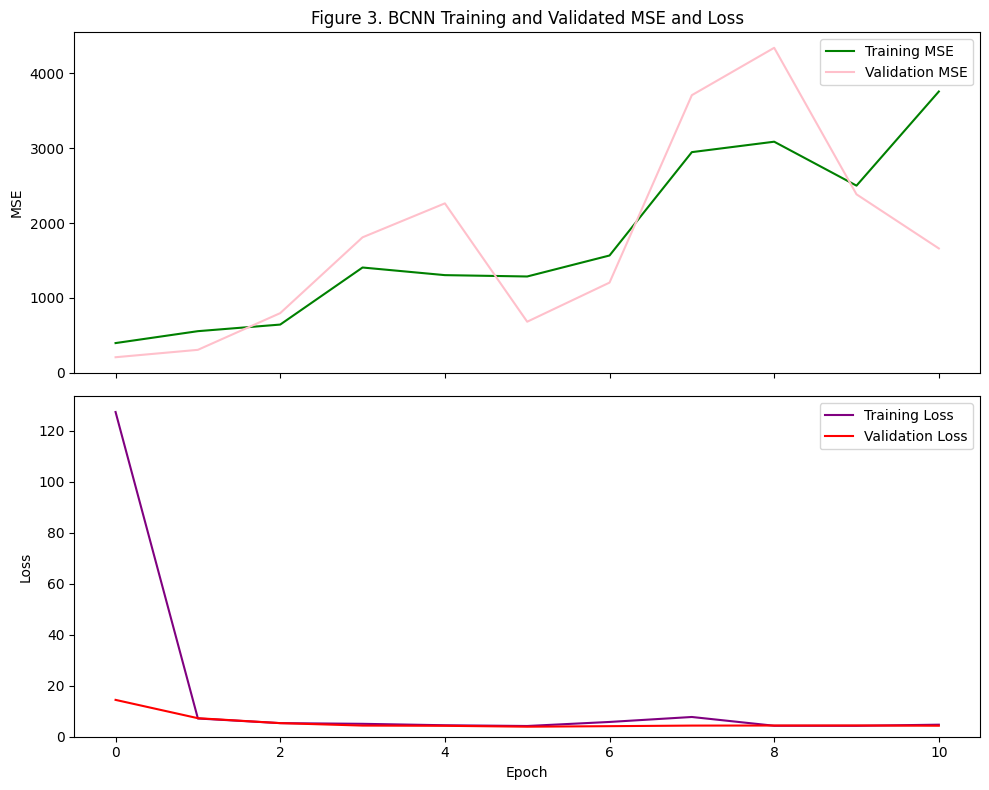

In [18]:
# Plotting training history

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
plt.xlabel('Epoch')

# Plotting accuracy and validated accuracy
ax1.set_title('Figure 3. BCNN Training and Validated MSE and Loss')
ax1.plot(BCNNhistory_earlystop.history['mse'], label='Training MSE', color='green')
ax1.plot(BCNNhistory_earlystop.history['val_mse'], label='Validation MSE', color='pink')
ax1.set_ylim(bottom=0.0)
ax1.set_ylabel('MSE')
ax1.legend()

# Plotting loss and validated loss
ax2.plot(BCNNhistory_earlystop.history['loss'], label='Training Loss', color='purple')
ax2.plot(BCNNhistory_earlystop.history['val_loss'], label='Validation Loss', color='red')
ax2.set_ylim(bottom=0.0)
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show();


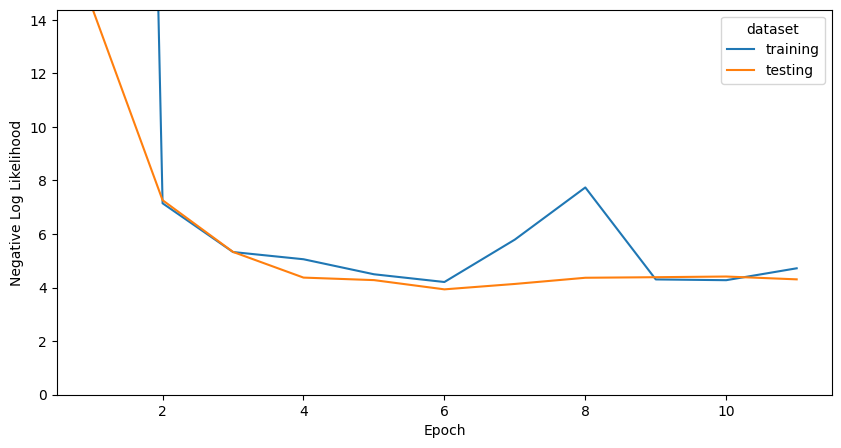

In [19]:
# Show training history
trainhist = pd.DataFrame({'training': BCNNhistory_earlystop.history['loss'], 'testing': BCNNhistory_earlystop.history['val_loss']})
trainhist['epoch'] = np.arange(1, len(BCNNhistory_earlystop.history['loss'])+1)
plt.figure(figsize=(10, 5))
sns.lineplot(data=pd.melt(trainhist, id_vars='epoch', value_name='NLL', var_name='dataset'), x='epoch', y='NLL', hue='dataset')
plt.ylim(0, np.quantile(trainhist['testing'], 0.999))
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood')

plt.show()

In [20]:
# Saving early stop model training history

# with open("early_stop_history.pkl", "wb") as file:
#     pickle.dump(BCNNhistory_earlystop, file)

# with open("early_stop_history.pkl", "rb") as file:
#     BCNNhistory_earlystop_pkl = pickle.load(file)
    

# 4) Model Prediction

## 4.1) Prediction without Monte Carlo Dropout

In [21]:
# Predict mean and log variance
mean_preds = BCNN(X_test).mean()
variance_preds = BCNN(X_test).variance()

In [22]:
# Create dataframe of observed and predicted test values using model
preds_df = pd.DataFrame({
    'Observations': y_test.numpy().ravel(),
    'Mean Predictions': mean_preds.numpy().ravel(),
    'Variance Predictions': variance_preds.numpy().ravel()
})

# Calculate R Squared and RMSE
r_squared = np.round(np.corrcoef(preds_df['Mean Predictions'], preds_df['Observations'])[0, 1] ** 2, 3)
rmse = np.round(np.sqrt(np.mean((preds_df['Mean Predictions'] - preds_df['Observations']) ** 2)), 3)

# Calculate CRPS
preds_df["Standard Dev"] = np.sqrt(preds_df["Variance Predictions"])
preds_df["CRPS"] = preds_df.apply(lambda row: ps.crps_gaussian(row['Observations'], row['Mean Predictions'], row['Standard Dev']), axis=1)
mean_crps = preds_df["CRPS"].mean()

# Evaluation metrics summary
eval_df = pd.DataFrame({
    "Evaluation Metric": ["R-squared", "RMSE", "Mean CRPS"],
    "Metric Score": [r_squared, rmse, mean_crps]
})

display(preds_df)
display(eval_df)

,Observations,Mean Predictions,Variance Predictions,Standard Dev,CRPS
0,7.0,2.764528,1238.462769,35.191799,8.427265
1,0.0,2.661264,1147.151245,33.869621,7.998539
2,0.0,0.623745,37.458420,6.120328,1.455628
3,0.0,2.747491,1223.194214,34.974194,8.259355
4,0.0,2.627142,1117.673584,33.431625,7.895121
...,...,...,...,...,...
312,0.0,0.623745,37.458420,6.120328,1.455628
313,0.0,2.464824,918.613953,30.308645,7.162902
314,0.0,0.623745,37.458420,6.120328,1.455628
315,0.0,2.669623,1132.790894,33.656960,7.949894


,Evaluation Metric,Metric Score
0,R-squared,0.000000
1,RMSE,6.973000
2,Mean CRPS,5.292068


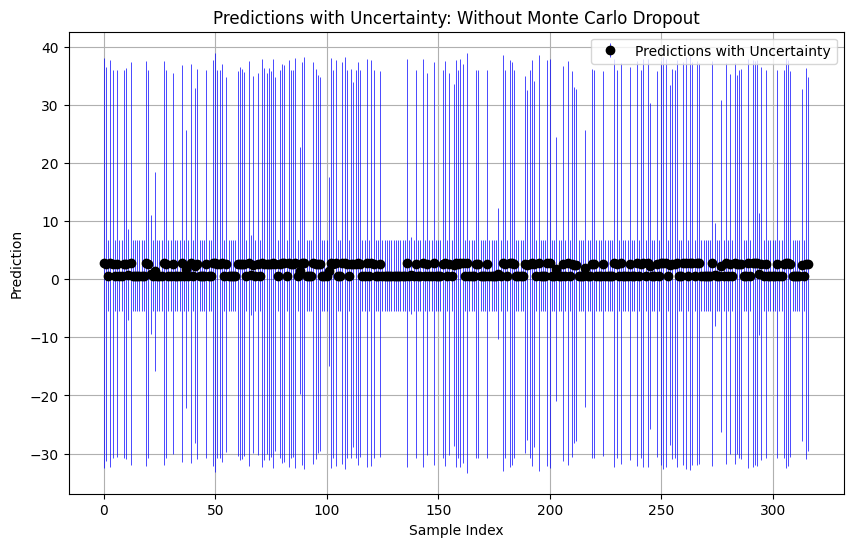

In [23]:
# Plotting uncertainty within predictions in test set

x = np.arange(317)  # Indices of predictions

plt.figure(figsize=(10, 6))
plt.errorbar(x, 
             np.squeeze(mean_preds), 
             yerr=np.sqrt(np.squeeze(variance_preds)), 
             fmt='o', 
             color='black',
             ecolor='blue',
             elinewidth=0.5,
             label='Predictions with Uncertainty')
plt.xlabel('Sample Index')
plt.ylabel('Prediction')
plt.title('Predictions with Uncertainty: Without Monte Carlo Dropout')
plt.legend()
plt.grid(True)
plt.show()


## 4.2) Prediction with Monte Carlo Dropout

In [24]:
def mc_dropout_predict(model, X, num_samples):
    
    predictions = []
    
    for _ in range(num_samples):
        predictions.append(model(X, training=True).mean())

    predictions = np.array(predictions)
    mean_predictions = predictions.mean(axis=0)
    uncertainty = predictions.var(axis=0)

    return mean_predictions, uncertainty

In [25]:
# MC Dropout
mean_predictions, uncertainty = mc_dropout_predict(BCNN, X_test, num_samples=50)


# Create dataframe of observed and predicted test values using model
mc_preds_df = pd.DataFrame({
    'Observations': y_test.numpy().ravel(),
    'Mean Predictions': mean_predictions.ravel(),
    'Variance Predictions': uncertainty.ravel()
})

# Calculate R Squared and RMSE
mc_r_squared = np.round(np.corrcoef(mc_preds_df['Mean Predictions'], mc_preds_df['Observations'])[0, 1] ** 2, 3)
mc_rmse = np.round(np.sqrt(np.mean((mc_preds_df['Mean Predictions'] - mc_preds_df['Observations']) ** 2)), 3)

# Calculate CRPS
mc_preds_df["Standard Dev"] = np.sqrt(mc_preds_df["Variance Predictions"])
mc_preds_df["CRPS"] = mc_preds_df.apply(lambda row: ps.crps_gaussian(row['Observations'], row['Mean Predictions'], row['Standard Dev']), axis=1)
mc_mean_crps = mc_preds_df["CRPS"].mean()

# Evaluation metrics summary
mc_eval_df = pd.DataFrame({
    "Evaluation Metric": ["R-squared", "RMSE", "Mean CRPS"],
    "Metric Score": [mc_r_squared, mc_rmse, mc_mean_crps]
})

display(mc_preds_df)
display(mc_eval_df)

,Observations,Mean Predictions,Variance Predictions,Standard Dev,CRPS
0,7.0,5.799933,40.447651,6.359847,1.576336
1,0.0,3.116985,49.438213,7.031231,2.185559
2,0.0,0.444849,0.487556,0.698252,0.272567
3,0.0,4.141828,36.438244,6.036410,2.501953
4,0.0,3.058473,23.941578,4.893013,1.882259
...,...,...,...,...,...
312,0.0,0.615765,0.296315,0.544349,0.378862
313,0.0,3.148937,30.260326,5.500939,1.985650
314,0.0,0.654148,0.542145,0.736305,0.389793
315,0.0,2.648886,32.335442,5.686426,1.812440


,Evaluation Metric,Metric Score
0,R-squared,0.000000
1,RMSE,7.048000
2,Mean CRPS,2.093095


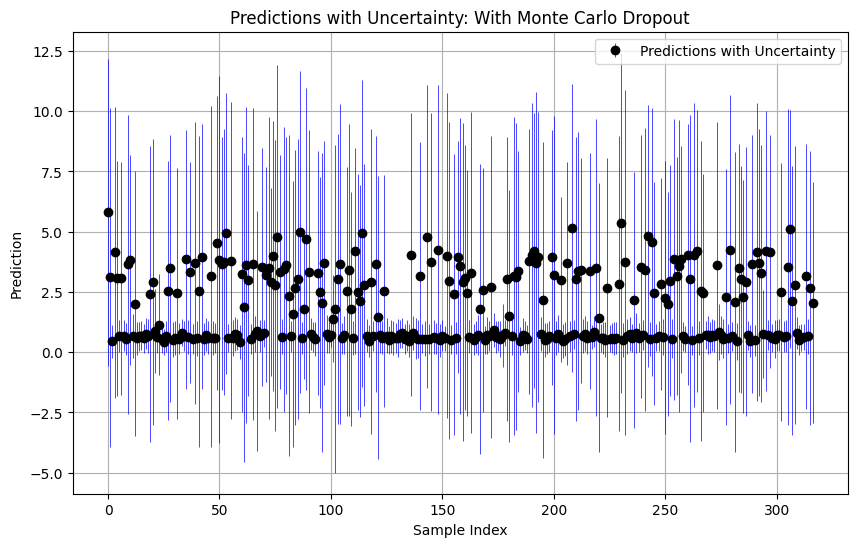

In [26]:
# Plotting uncertainty within predictions in test set

x = np.arange(317)  # Indices of predictions
mean_predictions = np.squeeze(mean_predictions)  # Remove singleton dimension
uncertainty = np.squeeze(uncertainty)

plt.figure(figsize=(10, 6))
plt.errorbar(x, 
             mean_predictions, 
             yerr=np.sqrt(uncertainty), 
             fmt='o', 
             color='black',
             ecolor='blue',
             elinewidth=0.5,
             label='Predictions with Uncertainty')
plt.xlabel('Sample Index')
plt.ylabel('Prediction')
plt.title('Predictions with Uncertainty: With Monte Carlo Dropout')
plt.legend()
plt.grid(True)
plt.show()

# 5) Apply The Model to the Area of Interest

In [38]:
# Creating batches
all_observations = labeled_patches_gdf.iloc[:, 0]

X_batches = tf.split(patches_trainset, num_or_size_splits=4, axis=0)
y_batches = np.array_split(all_observations, 4)

In [36]:
# MC Dropout for entire region
ig_mean_predictions, ig_uncertainty = mc_dropout_predict(BCNN, batches[0], num_samples=50)

In [53]:
# MC Dropout for entire region

batch_dfs = []

for i in range(len(X_batches)):
    batch_mean_predictions, batch_uncertainty = mc_dropout_predict(BCNN, batches[i], num_samples=50)
    
    batch_mc_preds_df = pd.DataFrame({
        'Observations': y_batches[i],
        'Mean Predictions': batch_mean_predictions.ravel(),
        'Variance Predictions': batch_uncertainty.ravel()
    })
    
    batch_dfs.append(batch_mc_preds_df)

In [5]:
# inglefield_mc_preds_df = pd.concat(batch_dfs, axis=0, ignore_index=True) # Concatenating batches
# inglefield_mc_preds_df = pd.concat([inglefield_mc_preds_df, labeled_patches_gdf], axis=1)

# Saving predictions

# with open("inglefield_mc_preds_df.pkl", "wb") as file:
#     pickle.dump(inglefield_mc_preds_df, file)

with open("inglefield_mc_preds_df.pkl", "rb") as file:
    inglefield_mc_preds_df = pickle.load(file)


In [6]:
# Dataframe of model predictions, mapping to polygon geometry for plotting

inglefield_mc_preds_gdf = gpd.GeoDataFrame(inglefield_mc_preds_df, geometry='geometry')
inglefield_mc_preds_gdf = inglefield_mc_preds_gdf.set_crs('EPSG:32619')

inglefield_mc_preds_gdf

,Observations,Mean Predictions,Variance Predictions,Cu,geometry
0,0.0,0.512404,0.333737,0.0,"POLYGON ((481215.000 8713575.000, 481215.000 8..."
1,0.0,0.612624,0.370934,0.0,"POLYGON ((481215.000 8715495.000, 481215.000 8..."
2,0.0,0.666348,0.430383,0.0,"POLYGON ((481215.000 8717415.000, 481215.000 8..."
3,0.0,0.531619,0.377589,0.0,"POLYGON ((481215.000 8719335.000, 481215.000 8..."
4,0.0,0.531560,0.356194,0.0,"POLYGON ((481215.000 8721255.000, 481215.000 8..."
...,...,...,...,...,...
2111,0.0,0.769466,0.431867,0.0,"POLYGON ((567615.000 8792295.000, 567615.000 8..."
2112,0.0,0.616134,0.439959,0.0,"POLYGON ((567615.000 8794215.000, 567615.000 8..."
2113,0.0,0.681468,0.538142,0.0,"POLYGON ((567615.000 8796135.000, 567615.000 8..."
2114,0.0,0.560786,0.348413,0.0,"POLYGON ((567615.000 8798055.000, 567615.000 8..."


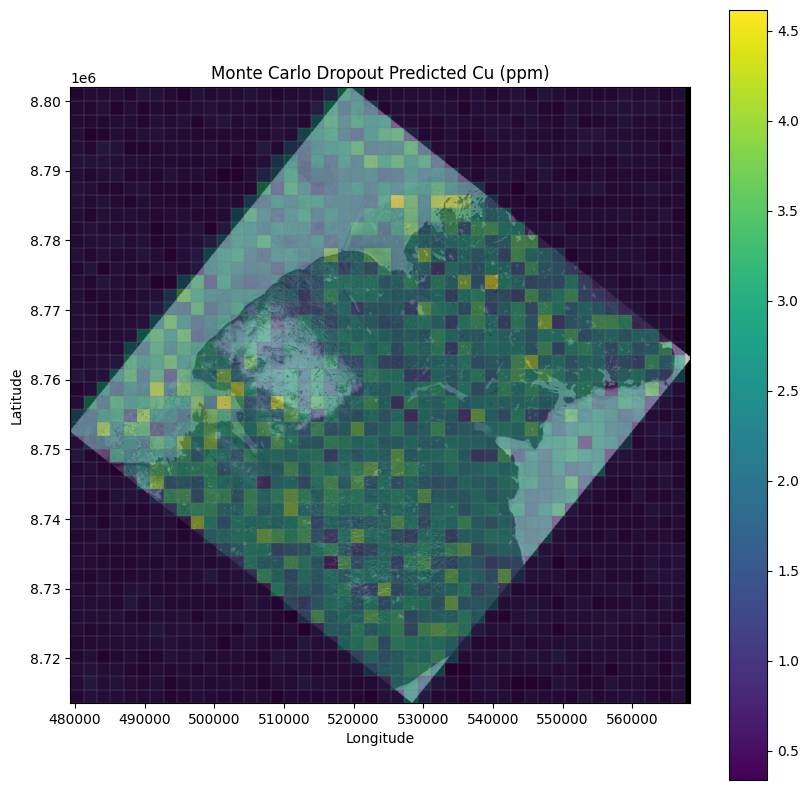

In [11]:
# Plotting prediction data and overlaying on raster image

fig, ax = plt.subplots(figsize=(10, 10))  # Customize the size as needed

with rasterio.open(file_path1) as dataset:
    img = dataset.read(1)

    show(dataset, ax=ax, title='Raster Image', cmap='gray')

    # Check if CRS matches
    if inglefield_mc_preds_gdf.crs != crs1:
        inglefield_mc_preds_gdf = inglefield_mc_preds_gdf.to_crs(crs1)

    # Plot polygons with transparency
    inglefield_mc_preds_gdf.plot(ax=ax, 
                                 column='Mean Predictions', 
                                 cmap='viridis', 
                                 legend=True, 
                                 alpha=0.5, 
                                 edgecolor='grey',
                                 linewidth=0.25)

    ax.set_xlim(bounds1[0], bounds1[2])  # xmin, xmax
    ax.set_ylim(bounds1[1], bounds1[3])  # ymin, ymax

    ax.set_title('Monte Carlo Dropout Predicted Cu (ppm)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Save plot
plt.savefig("MC preds overlain.svg", dpi=300, bbox_inches='tight')
    
plt.show()

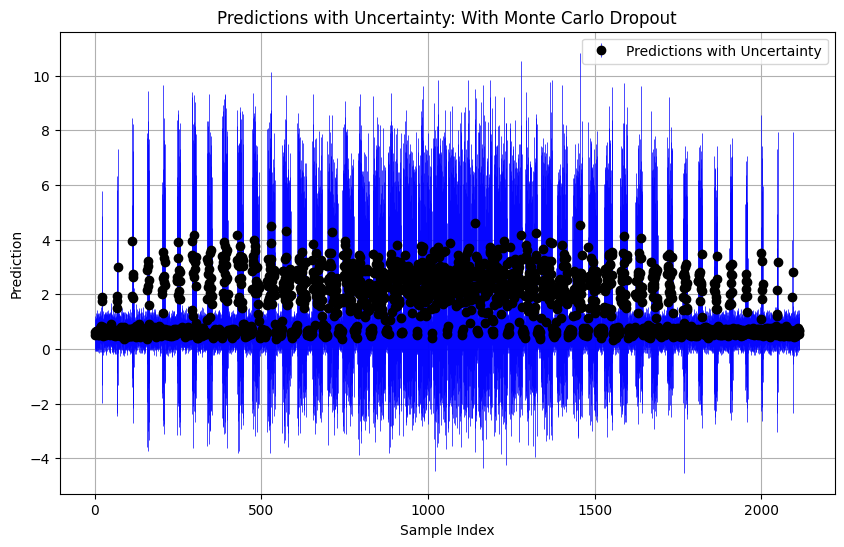

In [58]:
# Plotting uncertainty within predictions

x = np.arange(2116)  # Indices of predictions
mean_predictions = np.squeeze(mean_predictions)  # Remove singleton dimension
uncertainty = np.squeeze(uncertainty)

plt.figure(figsize=(10, 6))
plt.errorbar(x, 
             inglefield_mc_preds_df["Mean Predictions"], 
             yerr=np.sqrt(inglefield_mc_preds_df["Variance Predictions"]), 
             fmt='o', 
             color='black',
             ecolor='blue',
             elinewidth=0.5,
             label='Predictions with Uncertainty')
plt.xlabel('Sample Index')
plt.ylabel('Prediction')
plt.title('Predictions with Uncertainty: With Monte Carlo Dropout')
plt.legend()
plt.grid(True)
plt.show()